In [1]:
import numpy as np
import pandas as pd
import material as ml
import thinfilm as tm
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution, minimize

In [2]:
# open material
SiO2_raw = pd.read_csv('./paper/SiO2.csv')
ITO_raw = pd.read_csv('./paper/ITO.csv')
NB_raw = pd.read_csv('./paper/NB.csv')
# data acquisition
SiO2_w = SiO2_raw['nm'].values
SiO2_n = SiO2_raw['n'].values
ITO_w = ITO_raw['nm'].values
ITO_n = ITO_raw['n'].values
NB_w = NB_raw['nm'].values
NB_n = NB_raw['n'].values
corning_w = [435.8, 480, 486.1, 546.1, 589.3, 643.8, 656.3, 1300, 1541]
corning_n = [1.5247, 1.5247, 1.5244, 1.5203, 1.5183, 1.5161, 1.5160, 1.5051, 1.5023]

In [ ]:
# Sellmeier fitting
SiO2 = ml.Sellmeier(ml.sellmeier_fitting(SiO2_w, SiO2_n))
ITO = ml.Sellmeier(ml.sellmeier_fitting(ITO_w, ITO_n))
NB = ml.Sellmeier(ml.sellmeier_fitting(NB_w, NB_n))
Corning1737 = ml.Sellmeier(ml.sellmeier_fitting(corning_w, corning_n))

In [ ]:
#ml.save_material(SiO2, 'SiO2_NSNT')
#ml.save_material(ITO, 'ITO_NSNT')
#ml.save_material(NB, 'Nb2O5_NSNT')
#ml.save_material(Corning1737, 'Corning1737_NSNT')

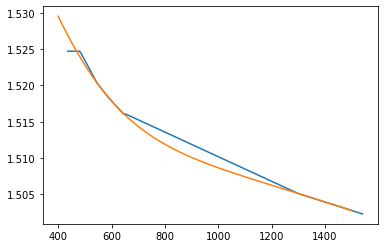

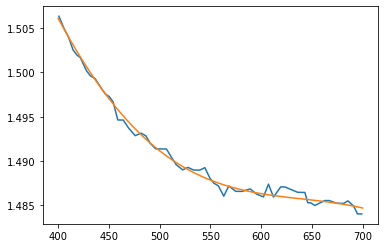

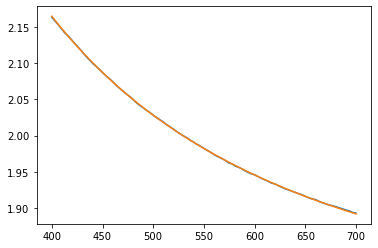

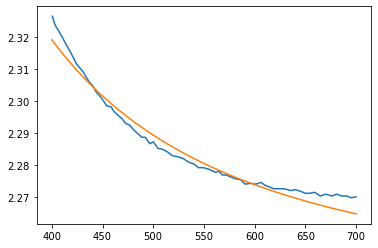

In [4]:
wl = np.linspace(400, 700)
wl2 = np.linspace(400, 1500)
plt.plot(corning_w, corning_n)
plt.plot(wl2, Corning1737.nvalues(wl2))
plt.show()
plt.plot(SiO2_w, SiO2_n)
plt.plot(wl, SiO2.nvalues(wl))
plt.show()
plt.plot(ITO_w, ITO_n)
plt.plot(wl, ITO.nvalues(wl))
plt.show()
plt.plot(NB_w, NB_n)
plt.plot(wl, NB.nvalues(wl))
plt.show()

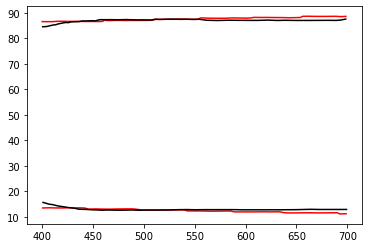

In [5]:
# paper target
igt = pd.read_csv('./paper/IGT.csv')
igr = pd.read_csv('./paper/IGR.csv')
iigt = pd.read_csv('./paper/IIGT.csv')
iigr = pd.read_csv('./paper/IIGR.csv')

igt_w = igt['nm'].values
igt_t = igt['RT'].values
igr_w = igr['nm'].values
igr_r = igr['RT'].values
iigt_w = iigt['nm'].values
iigt_t = iigt['RT'].values
iigr_w = iigr['nm'].values
iigr_r = iigr['RT'].values

plt.plot(igt_w, igt_t, '-r')
plt.plot(igr_w, igr_r, '-r')
plt.plot(iigt_w, iigt_t,'-k')
plt.plot(iigr_w, iigr_r,'-k')
plt.show()

In [6]:
air = ml.Non_Dispersion(1)
ITO.k = 6*10**-6
def fom(th):
    NB.k = th[0]
    SiO2.k = th[1]
    ITO_IM_glass = tm.Design(
        [air, ITO, SiO2, NB, Corning1737],
        [None, 30, 45, 9.5, None]
    )

    IM_glass = tm.Design(
        [air, SiO2, NB, Corning1737],
        [None, 45, 9.5, None]
    )
    IGT = 100*IM_glass.transmittance(igt_w)
    IGR = 100*IM_glass.reflectance(igr_w)
    IIGT = 100*ITO_IM_glass.transmittance(iigt_w)
    IIGR = 100*ITO_IM_glass.reflectance(iigr_w)
    return sum(abs(IGR-igr_r))+sum(abs(IIGR-iigr_r))+sum(abs(IGT-igt_t))+sum(abs(IIGT-iigt_t))

In [ ]:
sol = differential_evolution(fom, [(0,1),(0,1)])
print(sol.x)

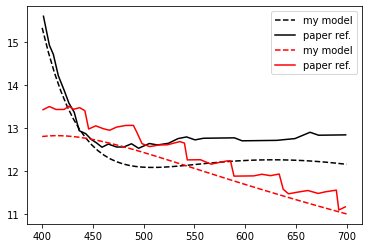

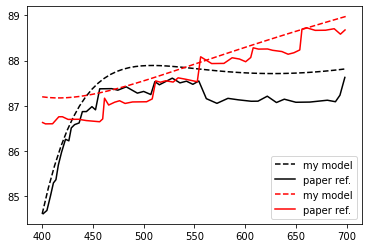

In [7]:
ITO_IM_glass = tm.Design(
    [air, ITO, SiO2, NB, Corning1737],
    [None, 30, 45, 9.5, None]
)

ITO_IM_glass_down = tm.Design(
    [Corning1737, NB, SiO2, ITO, air],
    [None, 9.5, 45, 30, None]
)

IM_glass = tm.Design(
    [air, SiO2, NB, Corning1737],
    [None, 45, 9.5, None]
)

IM_glass_down = tm.Design(
    [Corning1737, NB, SiO2, air],
    [None, 9.5, 40, None]
)

Bare_glass = tm.Design(
    [air, Corning1737],
    [None, None]
)
# 2nd reflection consideration
#
BR = Bare_glass.reflectance(wl)
BT = Bare_glass.transmittance(wl)

IIGR = ITO_IM_glass.reflectance(wl)
IIGT = ITO_IM_glass.transmittance(wl)
IIGRd = ITO_IM_glass_down.reflectance(wl)

IGR = IM_glass.reflectance(wl)
IGT = IM_glass.transmittance(wl)
IGRd = IM_glass_down.reflectance(wl)

IIGR_2nd = IIGR+(BR*(IIGT**2-IIGR*IIGRd))/(1-IIGRd*BR) 
IGR_2nd = IGR+(BR*(IGT**2-IGR*IGRd))/(1-IGRd*BR) 
IIGT_2nd = (IIGT*BT)/(1-IIGRd*BR) 
IGT_2nd = (IGT*BT)/(1-IGRd*BR) 

#plt.plot(wl, 100*IIGR, '--k')
plt.plot(wl, 100*IIGR_2nd, '--k', label = 'my model')
plt.plot(iigr_w, iigr_r,'-k', label = 'paper ref.')
#plt.plot(wl, 100*IGR, '--r')
plt.plot(wl, 100*IGR_2nd, '--r', label = 'my model')
plt.plot(igr_w, igr_r, '-r', label = 'paper ref.')
plt.legend(loc = 'best')
plt.savefig('1.png')
plt.show()
#plt.plot(wl, 100*IIGT, '--k')
plt.plot(wl, 100*IIGT_2nd, '--k', label = 'my model')
plt.plot(iigt_w, iigt_t,'-k', label = 'paper ref.')
#plt.plot(wl, 100*IGT, '--r')
plt.plot(wl, 100*IGT_2nd, '--r', label = 'my model')
plt.plot(igt_w, igt_t, '-r', label = 'paper ref.')
plt.legend(loc = 'best')
plt.savefig('2.png')
plt.show()

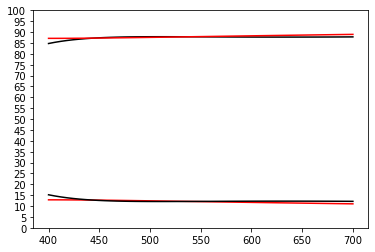

In [30]:
plt.plot(wl, 100*IIGT_2nd, '-k')
plt.plot(wl, 100*IGT_2nd, '-r')
plt.plot(wl, 100*IGR_2nd, '-r')
plt.plot(wl, 100*IIGR_2nd, '-k')
plt.yticks(np.linspace(0, 100, 21))
plt.savefig('si.png')
plt.show()